# Выбор локации для скважины <a id="intro"></a>

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание" data-toc-modified-id="Описание-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание</a></span></li><li><span><a href="#Загрузка-и-подготовка-данных" data-toc-modified-id="Загрузка-и-подготовка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Загрузка и подготовка данных</a></span></li><li><span><a href="#Обучение-и-проверка-модели" data-toc-modified-id="Обучение-и-проверка-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение и проверка модели</a></span></li><li><span><a href="#Подготовка-к-расчёту-прибыли" data-toc-modified-id="Подготовка-к-расчёту-прибыли-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Подготовка к расчёту прибыли</a></span></li><li><span><a href="#Расчёт-прибыли-и-рисков" data-toc-modified-id="Расчёт-прибыли-и-рисков-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Расчёт прибыли и рисков</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

## Описание

Добывающая компания «ГлавРосГосНефть» хочет решить, где бурить новую скважину.

Шаги для выбора локации обычно такие:
- В избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов;
- Строят модель для предсказания объёма запасов в новых скважинах;
- Выбирают скважины с самыми высокими оценками значений;
- Определяют регион с максимальной суммарной прибылью отобранных скважин.

Характеристики для каждой скважины в регионе уже известны. Требуется построить модель для определения региона, где добыча принесёт наибольшую прибыль.


**Условия:**
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки;
- Бюджет на разработку скважин в регионе — 10 млрд руб.;
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей;
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

## Загрузка и подготовка данных

Загрузим библиотеки.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

Подтянем данные.

In [2]:
data_1 = pd.read_csv("geo_data_0.csv")
data_2 = pd.read_csv("geo_data_1.csv")
data_3 = pd.read_csv("geo_data_2.csv")

Посмотрим, что из себя представлют данные.

In [3]:
df = [data_1, data_2, data_3]
for data in df:
    display(data.head(2))

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.22117,105.280062
1,2acmU,1.334711,-0.340164,4.36508,73.037750


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697


In [4]:
for data in df:
    print(data.info())
    print("*"*40)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
****************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
****************************************
<class 'pandas.core.frame.DataFrame'>
Ra

Есть ли дубликаты в данных? Посмотрим.

In [5]:
for data in df:
    display(data[data.duplicated()])

,id,f0,f1,f2,product


,id,f0,f1,f2,product


,id,f0,f1,f2,product


Поищем дубликаты в индентификаторах скважин.

In [6]:
for data in df:
    display(data[data["id"].duplicated(keep=False)].sort_values(by="id"))

,id,f0,f1,f2,product
66136,74z30,1.084962,-0.312358,6.990771,127.643327
64022,74z30,0.741456,0.459229,5.153109,140.771492
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502


,id,f0,f1,f2,product
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305


,id,f0,f1,f2,product
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641


Удалим дубликаты, оставим первую запись о каждой скважине.

In [7]:
for data in df:
    data.drop_duplicates(subset="id", keep="first", inplace=True)
    display(data[data["id"].duplicated(keep=False)].sort_values(by="id"))

,id,f0,f1,f2,product


,id,f0,f1,f2,product


,id,f0,f1,f2,product


Посмотрим описательную статистику.

In [8]:
for data in df:
    display(data.describe().T)

,count,mean,std,min,25%,50%,75%,max
f0,99990.0,0.500454,0.871844,-1.408605,-0.072572,0.502405,1.073626,2.362331
f1,99990.0,0.250141,0.504430,-0.848218,-0.200877,0.250252,0.700640,1.343769
f2,99990.0,2.502629,3.248149,-12.088328,0.287784,2.515969,4.715035,16.003790
product,99990.0,92.499684,44.288304,0.000000,56.497069,91.847928,128.563699,185.364347


,count,mean,std,min,25%,50%,75%,max
f0,99996.0,1.141209,8.965815,-31.609576,-6.298551,1.153055,8.620964,29.421755
f1,99996.0,-4.796608,5.119906,-26.358598,-8.267985,-4.813172,-1.332816,18.734063
f2,99996.0,2.494501,1.703579,-0.018144,1.000021,2.011475,3.999904,5.019721
product,99996.0,68.823916,45.944663,0.000000,26.953261,57.085625,107.813044,137.945408


,count,mean,std,min,25%,50%,75%,max
f0,99996.0,0.002002,1.732052,-8.760004,-1.162328,0.009424,1.158477,7.238262
f1,99996.0,-0.002159,1.730397,-7.084020,-1.174841,-0.009661,1.163523,7.844801
f2,99996.0,2.495084,3.473482,-11.970335,0.130269,2.484236,4.858720,16.739402
product,99996.0,94.998342,44.749573,0.000000,59.450028,94.925026,130.586815,190.029838


Также корреляцию между данными.

In [9]:
for data in df:
    display(data.corr())

,f0,f1,f2,product
f0,1.000000,-0.440717,-0.003211,0.143504
f1,-0.440717,1.000000,0.001764,-0.192351
f2,-0.003211,0.001764,1.000000,0.483631
product,0.143504,-0.192351,0.483631,1.000000


,f0,f1,f2,product
f0,1.000000,0.182279,-0.001810,-0.030523
f1,0.182279,1.000000,-0.002594,-0.010154
f2,-0.001810,-0.002594,1.000000,0.999397
product,-0.030523,-0.010154,0.999397,1.000000


,f0,f1,f2,product
f0,1.000000,0.000506,-0.000452,-0.001978
f1,0.000506,1.000000,0.000753,-0.001055
f2,-0.000452,0.000753,1.000000,0.445867
product,-0.001978,-0.001055,0.445867,1.000000


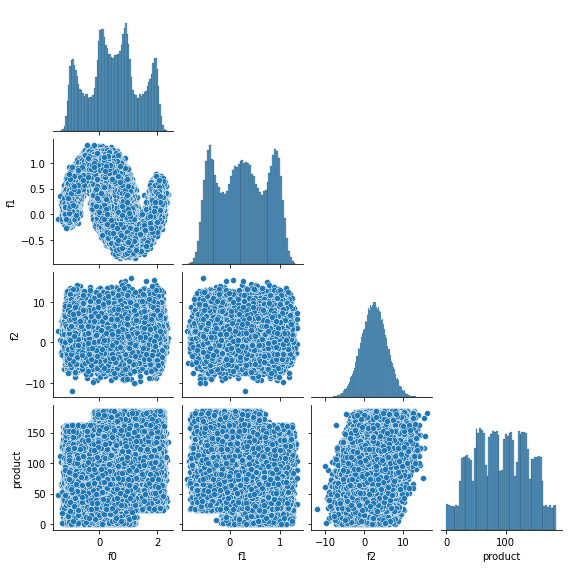

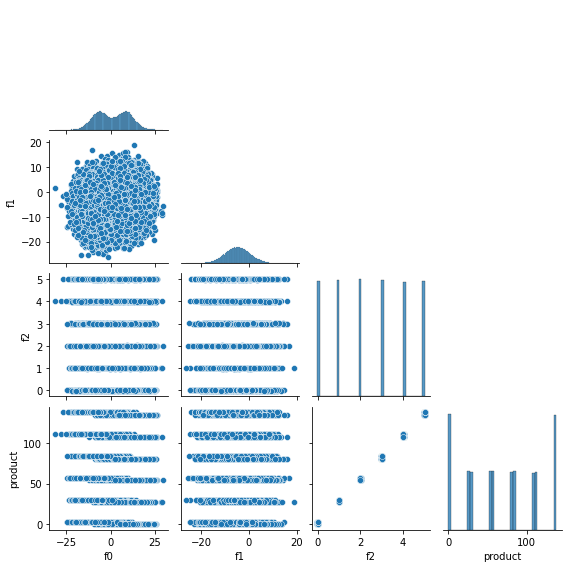

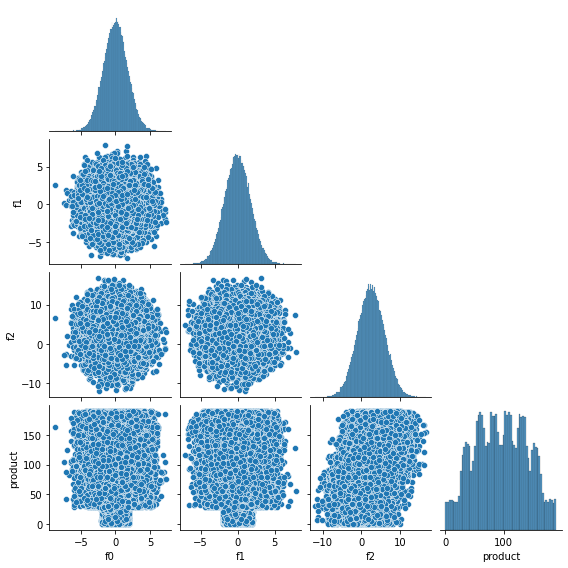

In [10]:
for data in df:
    sns.pairplot(data, corner=True, height=2, aspect=1)

**Выводы**

- В доступе имеются 3 датафрейма, каждый содержит информацию про скажины;
- Формат данных в каждом датафрейме представлен корректно;
- Обнаружены и устранены дубликаты по всех 3-х датафреймах;
- В 1-ом и 3-ем регионе целевой признак(объемы запасов в скважинах) имеет сильных разброс, данные менее шумные во 2-ом регионе;
- Во 2-ом регионе признак f2 сильно коррелируеют с целевым признаком, тогда как в 1-ом и 3-ем регионе корреляция не такая высокая, это можно увидеть также на графиках.

[В начало](#intro)

## Обучение и проверка модели

Данные чисты и готовы, идем дальше, обучим модель, протестируем и оценим ее качество.

In [11]:
number = ["1", "2", "3"]

predictions = {} # сюда будем записывать предсказания модели на валидационной выборке

# переберем датафреймы в цикле
for num, data in zip(number, df):
    # создадим признаки и целевой признак
    features = data.drop(["id", "product"], axis=1)
    target = data["product"]
    # разобъем данные на обучающую и валидационную выборки 75/25
    (features_train, 
     features_valid, 
     target_train, 
     target_valid) = (train_test_split(features, 
                                     target, 
                                     test_size=0.25, 
                                     random_state=12345))
    # выберем столбцы с количественными значениями      
    numeric = ["f0", "f1", "f2"]
    # создадим структуру данных для маштабирования
    scaler = StandardScaler()
    # маштабируем количественные значения
    features_train[numeric] = scaler.fit_transform(features_train[numeric])
    features_valid[numeric] = scaler.fit_transform(features_valid[numeric])
    # создадим модель линейней регресии   
    model = LinearRegression()
    # обучим модель    
    model.fit(features_train, target_train)
    # предскажем объемы запасов в скважинах и сохраним данные     
    predictions[num] = (target_valid, pd.Series(model.predict(features_valid),
                                            index=target_valid.index,
                                            name="preditions"))
                                            
    # рассчитаем показатели качества модели   
    rmse = mean_squared_error(target_valid, predictions[num][1])**0.5
    r2 = r2_score(target_valid, predictions[num][1])
    # выведем результаты
    print(f"Средний запас по региону {num}:", np.mean(predictions[num][1]))
    print("rmse:", rmse)
    print("r2:", r2)
    print("*"*45)

Средний запас по региону 1: 92.61351368955349
rmse: 37.84906865253047
r2: 0.27256374231348346
*********************************************
Средний запас по региону 2: 68.70320655419515
rmse: 1.0150341774197644
r2: 0.9995109849130915
*********************************************
Средний запас по региону 3: 95.06941970788125
rmse: 40.07570131845721
r2: 0.19556841642834621
*********************************************


**Выводы**

Наименьший разброс и как следствие наилучшее качество модели наблюдается по регину 2, коэффициент детерминации равен почти 1, средний запас по региону 2 ниже, чем у двух других. Однако, качество моделей по региону 1 и 3 очень низкое и имеет место быть сильный разброс, поэтому ответить однозначно в каком регионе средний запас нефти больше было бы не совсем корректно. 

[В начало](#intro)

## Подготовка к расчёту прибыли

Сколько баррелей нефти необходимо собрать с каждой скважины, чтобы выделенные расходы на реализацию проекта окупились? Посмотрим.

In [12]:
budget = 10e9
barrel_price = 450e3
well_count = 200

minimum_oil = budget/barrel_price/well_count
print(f"Чтобы выйти на 0 с каждой скважины надо собрать минимум {minimum_oil} тыс. баррелей нефти.")

Чтобы выйти на 0 с каждой скважины надо собрать минимум 111.11111111111111 тыс. баррелей нефти.


[В начало](#intro)

## Расчёт прибыли и рисков 

Напишем функцию для расчета прибыли.

In [13]:
def set_profit(target_valid, prediction_valid, price, count):
    pred = pd.Series(prediction_valid).sort_values(ascending=False)[:count]
    selected = target_valid[pred.index]
    return selected.sum() * barrel_price - budget

Рассчитаем прибыль с каждого региона.

In [14]:
count = 0
for target, prediction in (zip(pd.DataFrame(predictions.values())[0], 
                               pd.DataFrame(predictions.values())[1])):
    count += 1
    print(f"Прибыль по региона составила {count}: {int(set_profit(target, prediction, barrel_price, well_count))} руб.")

Прибыль по региона составила 1: 3378663203 руб.
Прибыль по региона составила 2: 2415086696 руб.
Прибыль по региона составила 3: 2501283853 руб.


In [15]:
state = np.random.RandomState(12345)
bootstrap_samples = 1000
count = 0


for target, prediction in (zip(pd.DataFrame(predictions.values())[0], 
                               pd.DataFrame(predictions.values())[1])):
    count += 1
    values = []
    
    for i in range(bootstrap_samples): 
        subsumple = prediction.sample(n=500, replace=True, random_state=state)
        values.append(set_profit(target, subsumple, barrel_price, 200))
        
    values = pd.Series(values)
    
    lower = round(values.quantile(0.025))
    higher = round(values.quantile(0.975))
    mean = round(values.mean())
    
    risk = values[values<0].count()/values.count()

    print(f"95-ый квантиль региона {count} по прибыли от {lower} до {higher} руб.")
    print(f"Средний размер прибыли в регионе {count}: {mean} руб.")
    print(f"Уровень риска в регионе {count}: {risk*100}%")
    print("*"*67)

95-ый квантиль региона 1 по прибыли от -142973127 до 892594363 руб.
Средний размер прибыли в регионе 1: 380859410 руб.
Уровень риска в регионе 1: 7.5%
*******************************************************************
95-ый квантиль региона 2 по прибыли от 73849212 до 917953818 руб.
Средний размер прибыли в регионе 2: 479159870 руб.
Уровень риска в регионе 2: 0.6%
*******************************************************************
95-ый квантиль региона 3 по прибыли от -216265050 до 811060708 руб.
Средний размер прибыли в регионе 3: 315531815 руб.
Уровень риска в регионе 3: 12.4%
*******************************************************************


**Выводы:**
- Наибольший риск получить убыток по региону 3, который составляет 12.4%, средний размер прибыли к тому же не самый высокий.
- По региону 1 риск убытка по меньше, составляет 7.5%, средняя прибыль по больше по сравнению с регионом 1.
- По региону 2 наблюдается наименший риск 0.6% средняя прибыль самая высокая.

Остановимся на регионе 2 при бурении скважин.

[В начало](#intro)

## Общий вывод

Мы проанализировали 3 региона с целью определить какой же регион выбрать для бурения скважин, чтобы вложения окупились с минимальными рисками. 

Обученная нами модель предсказала какую максимальную прибыль можно получить с каждого региона, если бурить 200 лучших скважин:
- Прибыль по региону составила 1: 3378663203 руб.
- Прибыль по региону составила 2: 2415086696 руб.
- Прибыль по региону составила 3: 2501283853 руб.

Если из каждого региона брать по 500 скважин случаным образом 1000 раз и из них выбрать 200 лучших скважин, то распределение прибыли следующее:

95-ый квантиль региона 1 по прибыли от -142973127 до 892594363 руб.

Средний размер прибыли в регионе 1: 380859410 руб.

Уровень риска в регионе 1: 7.5%
*******************************************************************
95-ый квантиль региона 2 по прибыли от 73849212 до 917953818 руб.

Средний размер прибыли в регионе 2: 479159870 руб.

Уровень риска в регионе 2: 0.6%
*******************************************************************
95-ый квантиль региона 3 по прибыли от -216265050 до 811060708 руб.

Средний размер прибыли в регионе 3: 315531815 руб.

Уровень риска в регионе 3: 12.4%
*******************************************************************

Несмотря на то, что регион 1 дал бы заказчику большую максимальную прибыль, при выборе данного региона для бурения скважин в конечном счете заказчик мог бы понести большие убытки. То же самое касается и 3 региона. Самым безопасным вариантом для заказчика является бурение скважин во 2-ом регионе, там у закачика наименьший риск получить убытки, всего 0.6%, при этом средний размер прибыли самый высокий. 

Только 2-ой регион подходит, заказчик готов принять на себя риск не более 2.5%.

Обученная нами модель позволит максимизировать прибыль заказчика.

[В начало](#intro)